Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [3]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [4]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [38]:
# Imports
import seaborn as sns
from sklearn import metrics
from math import sqrt

In [6]:
df.tail()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
49347,1.0,2,2016-06-02 05:41:05,"30TH/3RD, MASSIVE CONV 2BR IN LUXURY FULL SERV...",E 30 St,40.7426,-73.9790,3200,230 E 30 St,medium,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
49348,1.0,1,2016-04-04 18:22:34,"HIGH END condo finishes, swimming pool, and ki...",Rector Pl,40.7102,-74.0163,3950,225 Rector Place,low,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
49349,1.0,1,2016-04-16 02:13:40,Large Renovated One Bedroom Apartment with Sta...,West 45th Street,40.7601,-73.9900,2595,341 West 45th Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49350,1.0,0,2016-04-08 02:13:33,Stylishly sleek studio apartment with unsurpas...,Wall Street,40.7066,-74.0101,3350,37 Wall Street,low,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49351,1.0,2,2016-04-12 02:48:07,Look no further!!! This giant 2 bedroom apart...,Park Terrace East,40.8699,-73.9172,2200,30 Park Terrace East,low,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# Create the features matrix
X_prices = df['doorman']
X_prices_2D = X_prices[:,np.newaxis]

# Create the target array
y_prices = df['price']

In [22]:
# Import the train_test_split utility
from sklearn.model_selection import train_test_split

# Create the training and test
X_train, X_test, y_train, y_test = train_test_split(
    X_prices_2D, y_prices, test_size=0.2, random_state=42)

print('The training and testing feature: ', X_train.shape, y_train.shape)
print('The training and testing target: ', X_test.shape, y_test.shape)

The training and testing feature:  (39053, 1) (39053,)
The training and testing target:  (9764, 1) (9764,)


In [23]:
# Import the predictor
from sklearn.linear_model import LinearRegression

# Instantiate the class
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
# Coefficient
print(model.coef_)

# Intercept
print(model.intercept_)

# Print in equation form
print(f'\nprice = {model.coef_[0]} x doorman + ({model.intercept_})')

[990.20825258]
3152.778389905811

price = 990.2082525843672 x doorman + (3152.778389905811)


In [25]:
# Use the test for prediction
y_predict = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import r2_score
r2_score(y_test, y_predict)

0.07157912857171633

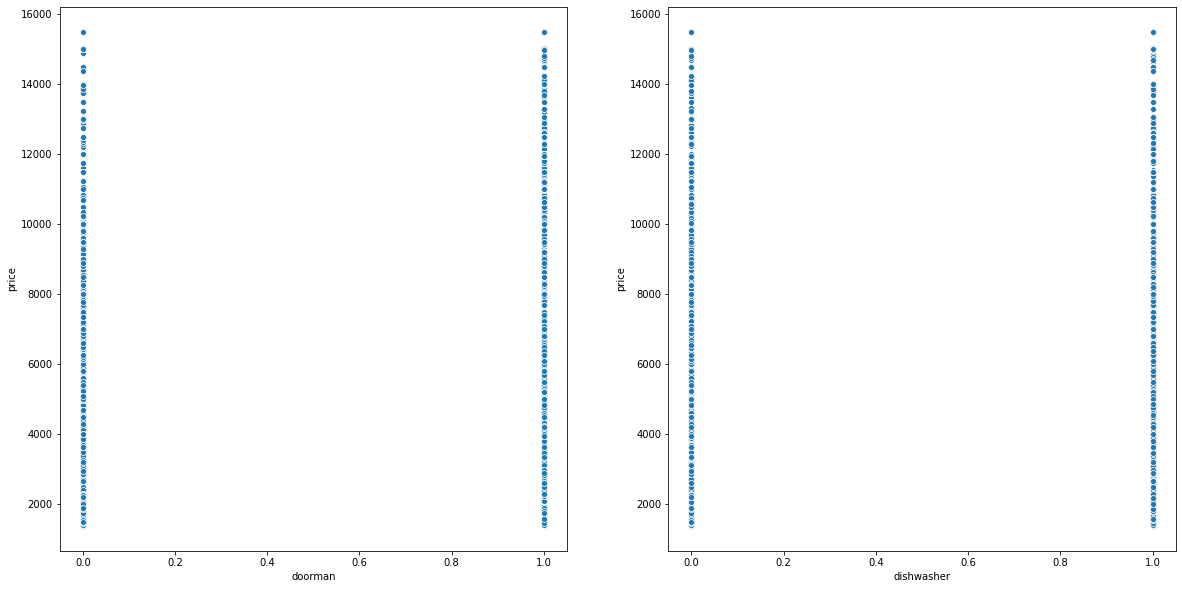

In [26]:
# Import
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
sns.scatterplot(x="doorman", y="price",
                data=df, ax = ax1)
sns.scatterplot(x="dishwasher", y="price",
                data=df, ax = ax2)

plt.savefig('two_features.png', transparent=False, dpi=200)
plt.show()

In [29]:
# Create the features matrix
X = df[['doorman', 'dishwasher']]

# creat the target array
y = df['price']

# Train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Import the estimator class
from sklearn.linear_model import LinearRegression

# Instantiate the class
model = LinearRegression()

# Fit the model
model.fit(X_prices, y_prices)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
# Coefficient
print(model.coef_)

# Intercept
print(model.intercept_)

[814.85192993 545.20735626]
3007.088664056284


In [33]:
# Use the test for prediction
y_pred = model.predict(X_test)

In [36]:
# MAE
mae = metrics.mean_absolute_error(y_test, y_pred)
mae

On average, my model errors by 1148.0 on the apartament price


In [40]:
# RMSE
rmse = sqrt(mae)
rmse

On average, my model errors by 34 on the apartament price


In [37]:
# R2 score
r2=metrics.r2_score(y_test, y_pred)
round(r2,2)

0.09